In [34]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

In [199]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DIC-0.5TA+0.83DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,1053.148478,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,1132.068050,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,1129.289180,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,1135.138190,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,1132.425550,0.948760,1
...,...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,1143.534000,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,1141.832000,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,1134.107000,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,1140.654000,0.493668,0


In [37]:

# 特徴量とラベルの分割
X = df.drop('label', axis=1)
y = df['label']
# パラメータグリッドの定義
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20]
}

rf = RandomForestClassifier(random_state=42)
#層化k分割交差検証の定義
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)
# GridSearchCVの実行
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_kfold,  # StratifiedKFoldを使用
    scoring='accuracy',
    n_jobs=-1
)

# モデルの学習
grid_search.fit(X, y)

# 結果の表示
print("最適なパラメータ:", grid_search.best_params_)
print("最高精度:", grid_search.best_score_)

# 結果をDataFrameに変換
results = pd.DataFrame(grid_search.cv_results_)

def plot_param_performance(param_name, results):
    plt.figure(figsize=(10, 6))

    # パラメータの一意な値を取得
    param_values = param_grid[param_name]

    # 各パラメータ値での平均精度を計算
    mean_scores = []
    std_scores = []

    for value in param_values:
        # パラメータが特定の値のときの結果を抽出
        mask = results[f'param_{param_name}'].astype(str) == str(value)
        scores = results[mask]['mean_test_score']
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    # プロット
    plt.errorbar(param_values, mean_scores, yerr=std_scores,
                marker='o',                # ポイントマーカー
                capsize=5,                 # エラーバーの横線の長さ
                capthick=1.5,             # エラーバーの横線の太さ
                elinewidth=1.5,           # エラーバーの縦線の太さ
                markersize=8,             # ポイントマーカーのサイズ
                markerfacecolor='white',   # マーカーの塗りつぶし色
                markeredgecolor='blue',    # マーカーの縁の色
                markeredgewidth=1.5)       # マーカーの縁の太さ

    # グラフの装飾
    plt.xlabel(param_name, fontsize=12)
    plt.ylabel('Mean Accuracy Score', fontsize=12)
    plt.title(f'Impact of {param_name} on Model Performance', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)

    # None値を'None'として表示（max_depthの場合）
    if param_name == 'max_depth':
        current_ticks = plt.xticks()[0]
        current_labels = plt.xticks()[1]
        new_labels = ['None' if str(label.get_text()) == 'nan' else str(label.get_text())
                     for label in current_labels]
        plt.xticks(current_ticks, new_labels)

    # y軸の範囲を適度に設定
    mean_min, mean_max = min(mean_scores), max(mean_scores)
    plt.ylim(mean_min - 0.05, mean_max + 0.05)

    plt.tight_layout()
    plt.show()
# # パラメータごとの精度の可視化
# def plot_param_performance(param_name, results):
#     plt.figure(figsize=(10, 6))

#     # パラメータの一意な値を取得
#     param_values = param_grid[param_name]

#     # 各パラメータ値での平均精度を計算
#     mean_scores = []
#     std_scores = []

#     for value in param_values:
#         # パラメータが特定の値のときの結果を抽出
#         mask = results[f'param_{param_name}'].astype(str) == str(value)
#         scores = results[mask]['mean_test_score']
#         mean_scores.append(scores.mean())
#         std_scores.append(scores.std())

#     # プロット
#     plt.errorbar(param_values, mean_scores, yerr=std_scores, marker='o')
#     plt.xlabel(param_name)
#     plt.ylabel('Mean Accuracy Score')
#     plt.title(f'Impact of {param_name} on Model Performance')
#     plt.grid(True)
#     plt.show()

# # 各パラメータについてプロット
# for param in ['n_estimators', 'max_depth', 'min_samples_split']:
#     plot_param_performance(param, results)

# # ヒートマップの作成（n_estimators vs max_depth）
# plt.figure(figsize=(12, 8))
# pivot_table = results.pivot_table(
#     values='mean_test_score',
#     index='param_n_estimators',
#     columns='param_max_depth'
# )
# sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
# plt.title('Accuracy Heatmap: n_estimators vs max_depth')
# plt.show()

# 上位10個のパラメータ組み合わせを表示
top_10_params = results.nlargest(10, 'mean_test_score')[
    ['params', 'mean_test_score', 'std_test_score']
]
print("\n上位10個のパラメータ組み合わせ:")
for i, row in top_10_params.iterrows():
    print(f"\nパラメータ: {row['params']}")
    print(f"平均精度: {row['mean_test_score']:.4f} (+/- {row['std_test_score']*2:.4f})")

/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (vers

KeyboardInterrupt: 

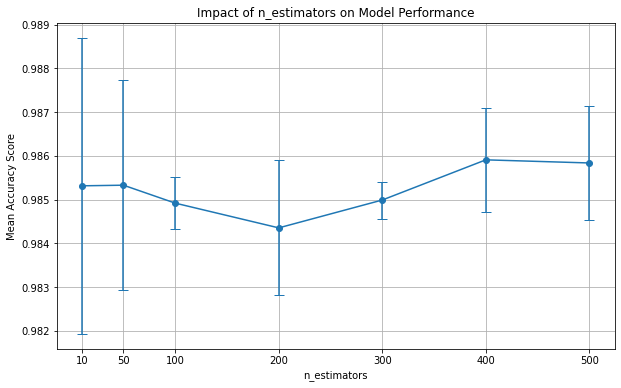

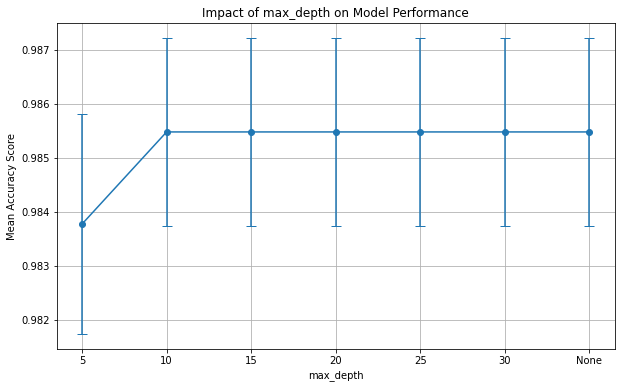

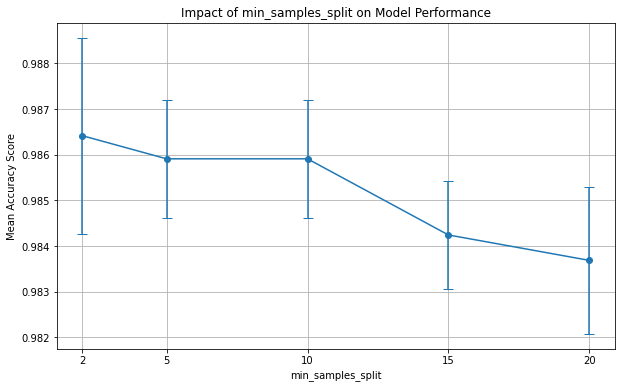

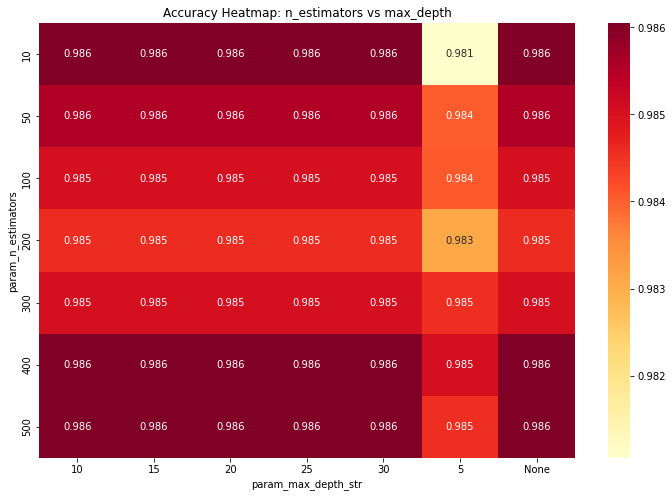

In [32]:
# def plot_param_performance(param_name, results):
#     plt.figure(figsize=(10, 6))

#     # パラメータの一意な値を取得
#     param_values = param_grid[param_name]

#     # max_depthのNoneを扱うための特別な処理
#     if param_name == 'max_depth':
#         # Noneを実際のプロット用に大きな値（例：35）に置き換える
#         plot_values = [35 if v is None else v for v in param_values]
#         # x軸のラベルを作成（Noneは'None'として表示）
#         x_labels = ['None' if v is None else str(v) for v in param_values]
#     else:
#         plot_values = param_values
#         x_labels = [str(v) for v in param_values]

#     # 各パラメータ値での平均精度を計算
#     mean_scores = []
#     std_scores = []

#     for value in param_values:
#         # パラメータが特定の値のときの結果を抽出
#         mask = results[f'param_{param_name}'].astype(str) == str(value)
#         scores = results[mask]['mean_test_score']
#         mean_scores.append(scores.mean())
#         std_scores.append(scores.std())

#     # プロット
#     plt.errorbar(plot_values, mean_scores, yerr=std_scores, marker='o')

#     # x軸のラベルを設定
#     plt.xticks(plot_values, x_labels)

#     plt.xlabel(param_name)
#     plt.ylabel('Mean Accuracy Score')
#     plt.title(f'Impact of {param_name} on Model Performance')
#     plt.grid(True)
#     plt.show()
def plot_param_performance(param_name, results):
    plt.figure(figsize=(10, 6))

    # パラメータの一意な値を取得
    param_values = param_grid[param_name]

    # max_depthのNoneを扱うための特別な処理
    if param_name == 'max_depth':
        # Noneを実際のプロット用に大きな値（例：35）に置き換える
        plot_values = [35 if v is None else v for v in param_values]
        # x軸のラベルを作成（Noneは'None'として表示）
        x_labels = ['None' if v is None else str(v) for v in param_values]
    else:
        plot_values = param_values
        x_labels = [str(v) for v in param_values]

    # 各パラメータ値での平均精度を計算
    mean_scores = []
    std_scores = []

    for value in param_values:
        # パラメータが特定の値のときの結果を抽出
        mask = results[f'param_{param_name}'].astype(str) == str(value)
        scores = results[mask]['mean_test_score']
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    # プロット（capsizeパラメータを追加）
    plt.errorbar(plot_values, mean_scores, yerr=std_scores, marker='o', capsize=5)

    # x軸のラベルを設定
    plt.xticks(plot_values, x_labels)

    plt.xlabel(param_name)
    plt.ylabel('Mean Accuracy Score')
    plt.title(f'Impact of {param_name} on Model Performance')
    plt.grid(True)
    plt.show()
# ヒートマップの修正版
def plot_heatmap(results):
    plt.figure(figsize=(12, 8))

    # max_depthの値を文字列に変換（Noneを'None'として扱う）
    results['param_max_depth_str'] = results['param_max_depth'].apply(lambda x: 'None' if x is None else str(x))

    pivot_table = results.pivot_table(
        values='mean_test_score',
        index='param_n_estimators',
        columns='param_max_depth_str'
    )

    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd')
    plt.title('Accuracy Heatmap: n_estimators vs max_depth')
    plt.show()

# 各パラメータについてプロット
for param in ['n_estimators', 'max_depth', 'min_samples_split']:
    plot_param_performance(param, results)

# ヒートマップの表示
plot_heatmap(results)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (vers

最適なパラメータ: {'max_depth': 10, 'n_estimators': 10}
最高精度: 0.9900


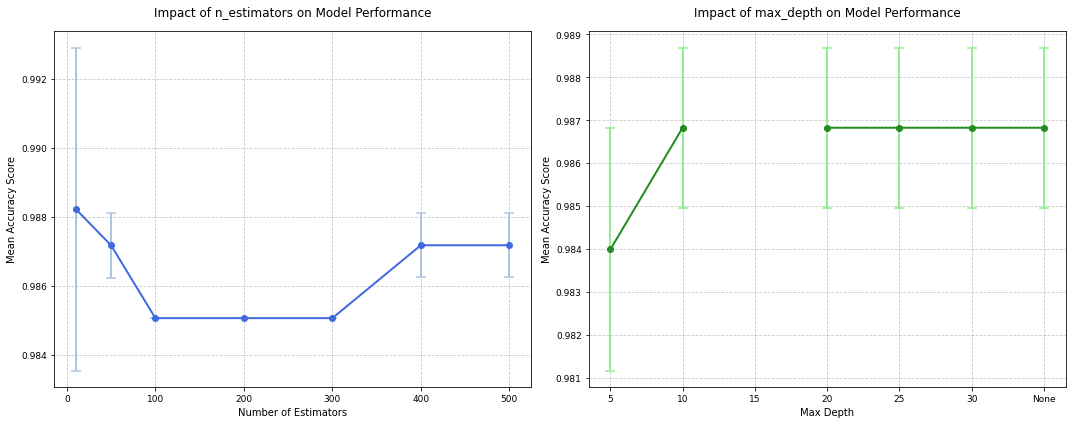

In [33]:
# パラメータグリッドの定義（min_samples_split=2で固定）
param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, 25, 30, None]
}

# モデルの初期化
rf = RandomForestClassifier(
    random_state=42,
    min_samples_split=2  # 固定値
)

# 層化k分割交差検証の定義
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# GridSearchCVの実行
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# モデルの学習
grid_search.fit(X, y)

# 結果の表示
print("最適なパラメータ:", grid_search.best_params_)
print("最高精度: {:.4f}".format(grid_search.best_score_))

def plot_parameter_performance(results):
    """
    n_estimatorsとmax_depthのパラメータ探索結果を2つのサブプロットで表示
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # フォントサイズの設定
    TITLE_SIZE = 12
    LABEL_SIZE = 10
    TICK_SIZE = 9

    # n_estimatorsのプロット
    n_estimators_values = sorted(list(set(results['param_n_estimators'])))
    mean_scores = []
    std_scores = []

    for value in n_estimators_values:
        mask = results['param_n_estimators'] == value
        scores = results[mask]['mean_test_score']
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    ax1.errorbar(n_estimators_values, mean_scores, yerr=std_scores,
                 marker='o', capsize=5, capthick=1.5, markersize=6,
                 color='royalblue', ecolor='lightsteelblue', linewidth=2)

    ax1.set_xlabel('Number of Estimators', fontsize=LABEL_SIZE)
    ax1.set_ylabel('Mean Accuracy Score', fontsize=LABEL_SIZE)
    ax1.set_title('Impact of n_estimators on Model Performance',
                  fontsize=TITLE_SIZE, pad=15)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.tick_params(axis='both', labelsize=TICK_SIZE)

    # max_depthのプロット
    max_depth_values = sorted([x for x in set(results['param_max_depth']) if x is not None])
    plot_values = max_depth_values + [35]  # Noneの代わりに35を使用
    mean_scores = []
    std_scores = []

    for value in list(set(results['param_max_depth'])):
        mask = results['param_max_depth'] == value
        scores = results[mask]['mean_test_score']
        mean_scores.append(scores.mean())
        std_scores.append(scores.std())

    ax2.errorbar(plot_values, mean_scores, yerr=std_scores,
                 marker='o', capsize=5, capthick=1.5, markersize=6,
                 color='forestgreen', ecolor='lightgreen', linewidth=2)

    # x軸のラベルを設定（最後の値をNoneとして表示）
    x_labels = [str(v) for v in max_depth_values] + ['None']
    ax2.set_xticks(plot_values)
    ax2.set_xticklabels(x_labels)

    ax2.set_xlabel('Max Depth', fontsize=LABEL_SIZE)
    ax2.set_ylabel('Mean Accuracy Score', fontsize=LABEL_SIZE)
    ax2.set_title('Impact of max_depth on Model Performance',
                  fontsize=TITLE_SIZE, pad=15)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.tick_params(axis='both', labelsize=TICK_SIZE)

    # グラフ全体の設定
    plt.tight_layout()
    plt.show()

# 結果の可視化
results_df = pd.DataFrame(grid_search.cv_results_)
plot_parameter_performance(results_df)

In [38]:

X = df.drop('label', axis=1)  # 目的変数の列名を'target'と仮定
y = df['label']

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 異なるn_estimatorsでの精度を格納するリスト
n_estimators_list = [10, 50, 100, 200, 300, 400, 500]
cv_scores = []

# 各n_estimatorsでクロスバリデーションを実行
for n_est in n_estimators_list:
    rf = RandomForestClassifier(
        n_estimators=n_est,
        random_state=42
    )

    # 5分割交差検証を実行
    scores = cross_val_score(
        rf, X_train, y_train,
        cv=5,
        scoring='accuracy'
    )

    # 平均スコアを保存
    cv_scores.append(scores.mean())

    print(f'n_estimators={n_est}:')
    print(f'Cross-validation scores: {scores}')
    print(f'Average CV score: {scores.mean():.4f}\n')

# 結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_list, cv_scores, marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Cross-validation Accuracy')
plt.title('Random Forest Performance vs Number of Estimators')
plt.grid(True)

# x軸の目盛りを設定
plt.xticks(n_estimators_list)

# 保存
plt.savefig('rf_performance.png')
plt.close()

# 最適なn_estimatorsでモデルを学習
best_n_estimators = n_estimators_list[np.argmax(cv_scores)]
print(f'\nBest number of estimators: {best_n_estimators}')

# 最適なモデルでテストデータの評価
best_rf = RandomForestClassifier(
    n_estimators=best_n_estimators,
    random_state=42
)
best_rf.fit(X_train, y_train)
test_score = best_rf.score(X_test, y_test)
print(f'Test set accuracy with best model: {test_score:.4f}')

n_estimators=10:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966

n_estimators=50:
Cross-validation scores: [1.         0.98648649 0.99661017 0.99661017 1.        ]
Average CV score: 0.9959

n_estimators=100:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966

n_estimators=200:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966

n_estimators=300:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966

n_estimators=400:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966

n_estimators=500:
Cross-validation scores: [1.         0.98648649 1.         0.99661017 1.        ]
Average CV score: 0.9966


Best number of estimators: 10
Test set accuracy with best model: 1.0000


最適なn_estimators: 7
最高精度: 0.9978378378378379


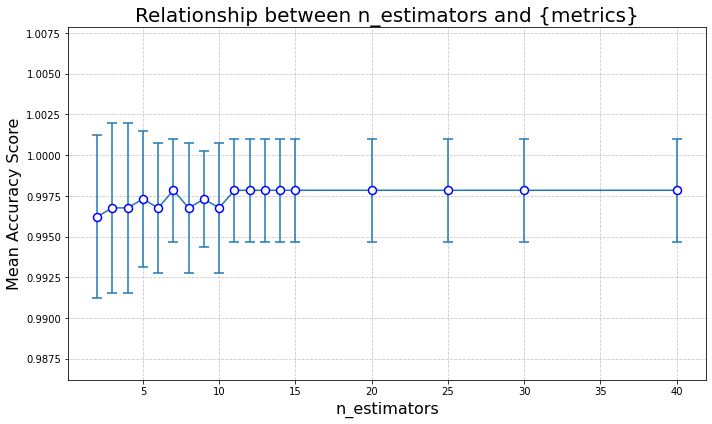


各n_estimatorsでの性能:

n_estimators = 2
平均精度: 0.9962 (+/- 0.0100)

n_estimators = 3
平均精度: 0.9968 (+/- 0.0105)

n_estimators = 4
平均精度: 0.9968 (+/- 0.0105)

n_estimators = 5
平均精度: 0.9973 (+/- 0.0084)

n_estimators = 6
平均精度: 0.9968 (+/- 0.0079)

n_estimators = 7
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 8
平均精度: 0.9968 (+/- 0.0079)

n_estimators = 9
平均精度: 0.9973 (+/- 0.0059)

n_estimators = 10
平均精度: 0.9968 (+/- 0.0079)

n_estimators = 11
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 12
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 13
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 14
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 15
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 20
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 25
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 30
平均精度: 0.9978 (+/- 0.0063)

n_estimators = 40
平均精度: 0.9978 (+/- 0.0063)


In [122]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt

# 特徴量とラベルの分割
X = df.drop('label', axis=1)
y = df['label']

# パラメータグリッドの定義（n_estimatorsのみ）
param_grid = {
    'n_estimators': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25, 30, 40]
}

# ランダムフォレストの初期化（他のパラメータはデフォルト値）
rf = RandomForestClassifier(random_state=42)

# 層化k分割交差検証の定義
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# GridSearchCVの実行
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1
)

# モデルの学習
grid_search.fit(X, y)

# 結果の表示
print("最適なn_estimators:", grid_search.best_params_['n_estimators'])
print("最高精度:", grid_search.best_score_)

# 結果をDataFrameに変換
results = pd.DataFrame(grid_search.cv_results_)

# n_estimatorsの性能をプロット
plt.figure(figsize=(10, 6))

# 各n_estimators値での平均精度を取得
n_estimators_values = param_grid['n_estimators']
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

# プロット
plt.errorbar(n_estimators_values, mean_scores, yerr=std_scores,
            marker='o',
            capsize=5,
            capthick=1.5,
            elinewidth=1.5,
            markersize=8,
            markerfacecolor='white',
            markeredgecolor='blue',
            markeredgewidth=1.5)

# グラフの装飾
plt.xlabel('n_estimators', fontsize=16)
plt.ylabel('Mean Accuracy Score', fontsize=16)
plt.title('Relationship between n_estimators and {metrics}', fontsize=20)
plt.grid(True, linestyle='--', alpha=0.7)

# y軸の範囲を適度に設定
mean_min, mean_max = mean_scores.min(), mean_scores.max()
plt.ylim(mean_min - 0.01, mean_max + 0.01)

plt.tight_layout()
plt.show()

# 各n_estimatorsでの詳細な結果を表示
print("\n各n_estimatorsでの性能:")
for i, n_est in enumerate(n_estimators_values):
    print(f"\nn_estimators = {n_est}")
    print(f"平均精度: {mean_scores[i]:.4f} (+/- {std_scores[i]*2:.4f})")

In [196]:
###生データ
# # Excelファイルの読み込み
excel_file_path = 'all_data_2.xlsx'
csv_file_path = 'all_data_2.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['水深','Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', 'pH', 'Pressure',
                  'O2 weiss 1970', '日時', '場所', 'No.', 'Depth[m]', 'Salinity', 'AOU', 'excess DIC', 'nDIC+0.768DO','DIC-0.5TA+0.83DO', 'DO Saturation']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data_2.csv


,pCO2,T,TA,DO,DIC,label
18,609.054405,26.1010,2153.3,201.181294,1962.818004,1
135,564.930029,18.0400,2230.0,223.335000,2061.700000,1
136,566.704024,18.0700,2229.6,219.746000,2061.700000,1
137,569.721742,18.2300,2229.6,226.793000,2061.700000,1
138,568.501477,18.1700,2229.7,223.585000,2061.700000,1
...,...,...,...,...,...,...
2060,542.771000,10.6016,2325.8,149.800000,2182.100000,0
2061,557.977000,10.1420,2322.4,140.400000,2186.500000,0
2062,519.493000,10.7688,2326.1,147.900000,2174.400000,0
2063,538.981000,10.0288,2323.8,143.800000,2183.200000,0


In [194]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.', 'DIC-0.5TA+0.83DO']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,0.948760,1
...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,0.493668,0


In [144]:
# 特徴量とラベルの分割
X = df.drop('label', axis=1)
y = df['label']

rf = RandomForestClassifier(n_estimators=50, random_state=42)

# 層化k分割交差検証の定義
stratified_kfold = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

# 交差検証でスコアを計算
scores = cross_val_score(
    rf,
    X,
    y,
    cv=stratified_kfold,
    scoring='recall',
    n_jobs=-1
)

# 結果の表示
print("交差検証の結果:")
print(f"各分割でのAccuracy: {scores}")
print(f"平均Accuracy: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (vers

交差検証の結果:
各分割でのAccuracy: [0.83333333 0.5        1.         0.8        1.        ]
平均Accuracy: 0.8267 (+/- 0.3661)


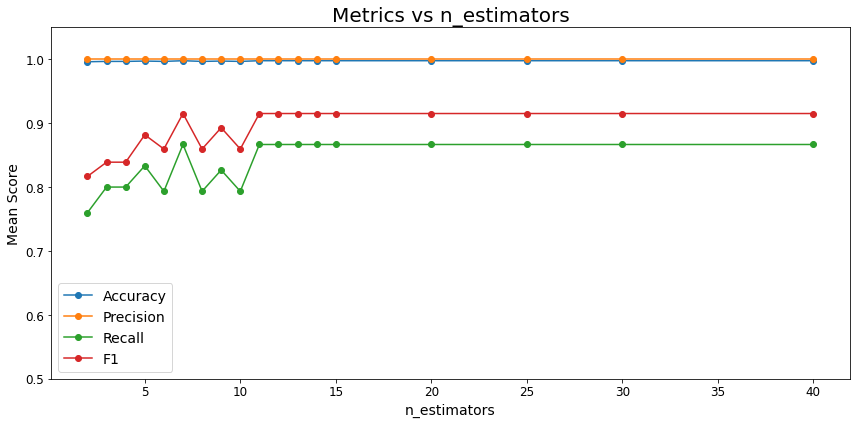


各メトリクスでの最適な結果:

Accuracy:
最適なn_estimators: 7
最高スコア: 0.9978

Precision:
最適なn_estimators: 2
最高スコア: 1.0000

Recall:
最適なn_estimators: 7
最高スコア: 0.8667

F1:
最適なn_estimators: 7
最高スコア: 0.9152


In [200]:
# 特徴量とラベルの分割
X = df.drop('label', axis=1)
y = df['label']

# パラメータグリッドの定義
param_grid = {
    'n_estimators': [2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30,40]
    # 'n_estimators': [10,50,100,200,300,400,500]
}

# スコアリング指標の定義
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# ランダムフォレストの初期化
rf = RandomForestClassifier(random_state=42)

# 層化k分割交差検証の定義
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCVの実行
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=stratified_kfold,
    scoring=scoring,
    n_jobs=-1,
    refit='accuracy'
)

# モデルの学習
grid_search.fit(X, y)

# 結果をDataFrameに変換
results = pd.DataFrame(grid_search.cv_results_)

# グラフの描画
fig, ax = plt.subplots(figsize=(12, 6))

for metric in metrics:
    # 平均スコアの取得
    mean_scores = results[f'mean_test_{metric}']

    # 各メトリクスのプロット
    ax.plot(param_grid['n_estimators'], mean_scores, marker='o', label=metric.capitalize())

# グラフの装飾
ax.set_xlabel('n_estimators', fontsize=14)
ax.set_ylabel('Mean Score', fontsize=14)
ax.set_title('Metrics vs n_estimators', fontsize=20)
ax.grid(False)
ax.legend(fontsize=14)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(bottom=0.5, top=1.05)
plt.tight_layout()
plt.show()

# 各メトリクスの最適値と対応するn_estimatorsを表示
print("\n各メトリクスでの最適な結果:")
for metric in metrics:
    best_idx = results[f'mean_test_{metric}'].argmax()
    best_n_estimators = param_grid['n_estimators'][best_idx]
    best_score = results[f'mean_test_{metric}'][best_idx]

    print(f"\n{metric.capitalize()}:")
    print(f"最適なn_estimators: {best_n_estimators}")
    print(f"最高スコア: {best_score:.4f}")

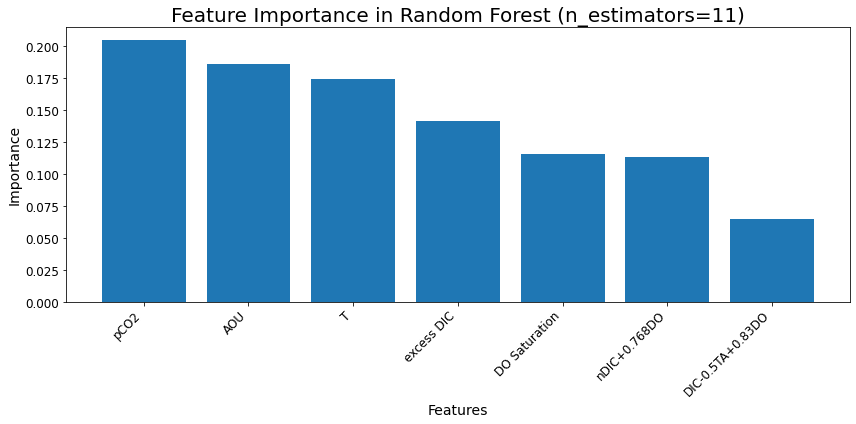


特徴量の重要度:
pCO2: 0.2045
AOU: 0.1863
T: 0.1740
excess DIC: 0.1415
DO Saturation: 0.1155
nDIC+0.768DO: 0.1136
DIC-0.5TA+0.83DO: 0.0646


In [201]:
# n_estimators=11 の Random Forest モデルを作成
best_rf = RandomForestClassifier(n_estimators=11, random_state=42)
best_rf.fit(X, y)

# 特徴量の重要度を取得
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_rf.feature_importances_
})

# 重要度で降順にソート
feature_importance = feature_importance.sort_values('importance', ascending=False)

# 特徴量の重要度を棒グラフで可視化
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance['importance'])
plt.xticks(range(len(feature_importance)), feature_importance['feature'], rotation=45, ha='right',fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Importance', fontsize=14)
plt.title('Feature Importance in Random Forest (n_estimators=11)', fontsize=20)
plt.tight_layout()
plt.show()

# 特徴量の重要度を数値で表示
print("\n特徴量の重要度:")
for idx, row in feature_importance.iterrows():
    print(f"{row['feature']}: {row['importance']:.4f}")